# Final Assignment of the course "Applied Data Science Capstone"

## Introduction

Everyone needs a place to live. There are many types of buildings that give us as a roof over our heads. It can be a house, villa, or flat. Each person at some point in life has to choose whether to buy a house, and if so, which one. Most people also wonder why are they so expensive? Regardless of motives of buying and selling real estate, both sides agree on a price. It is always good to know how much a house is worth, what is the expected transaction price. An accurate prediction on the house price is important to prospective homeowners, developers, investors, appraisers, tax assessors and other real estate market participants, such as, mortgage lenders and insurers. Furthermore, it may be even more important why is the price like that, what has an impact on it. In this project I will try to build a predictive model for house prices. I will use standard set of variables characterizing each property (such as property size, condition or number of rooms). In addition I will try to include some location-related features that will be created with the use of Foursquare location data.

## Data description

* Dataset used for this project has been found on Kaggle repository. It contains sale prices of houses located in King County, in the U.S state of Washington. Data includes houses sold between May 2014 and May 2015. In this dataset one can also find many variables that characterize each property (like for example: area, condition, number of rooms, location, etc.). Original dataset has above 20 000 of observations and 21 variables and is of a very good quality, as there were no missing values.
<br/><br/>
* In addition Forsquare API have been used to get the most common venues of given regions in King County.


## Load all important libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

from geopy.geocoders import Nominatim
import folium
import requests
from sklearn.cluster import KMeans
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, FeaturesData, Pool

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)

## Load data, basic information about the dataset and preliminary data transformations

In [6]:
df = pd.read_csv('kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

Almost all variables are initially stored as numbers, only date has been read as an object. One can also find that date is coded in a specific way - as a long sequence of characters 'YYYYMMDDT000000'. We need to transform date into desired form. Then we can use it to extract year. In addition we will transforme zipcode from integer to object as we will use this variable as a label for different regions.

In [8]:
df['date'] = df['date'].str[0:8]
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['year'] = df['date'].dt.year
df['id'] = df['id'].astype(str)
df['zipcode'] = df['zipcode'].astype(str)

We can display basic statistics.

In [9]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,47.56,-122.21,1986.55,12768.46,2014.32
std,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,0.14,0.14,685.39,27304.18,0.47
min,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,47.16,-122.52,399.00,651.00,2014.00
25%,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,47.47,-122.33,1490.00,5100.00,2014.00
50%,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,47.57,-122.23,1840.00,7620.00,2014.00
75%,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,47.68,-122.12,2360.00,10083.00,2015.00
max,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,47.78,-121.31,6210.00,871200.00,2015.00


In [10]:
df.isna().sum().sum()

0

Dataset seems to be of a good quality, it does not contain any missings.

Variables such as id and date could be probably dropped but they can still be useful in a data preprocessing stage. Based on ID we can verify whether we have any duplicates in the dataset.

It turns out that there are 175 houses that were sold 2 times and 1 house even 3 times. This issue may distort our analysis, because houses that were sold multiple times have the same characteristic (the same predictors) but different prices (different value of target variable).

We can see 3 options: first and the easiest would be to drop all these observations; second one is to take only the most current transcation for each house (eg. if the house was sold in July 2014 and then in January 2015 we only keep the later observation - January 2015, and remove the other one); last one approach could be to compute mean price for particular house based on all transcations related to this house and use only one observation with replaced price (we replace original price with calculated average).

Finally we decided to follow the second approach, so we left only the most current transaction.

In [11]:
df.sort_values(['id', 'date'], inplace = True) 
df.drop_duplicates(subset ='id', keep = 'last', inplace = True)
df = df.reset_index(drop=True)
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year
0,1000102,2015-04-22,300000.00,6,3.00,2400,9373,2.00,0,0,3,7,2400,0,1991,0,98002,47.33,-122.21,2060,7316,2015
1,100100050,2014-11-12,275000.00,3,1.00,1320,11090,1.00,0,0,3,7,1320,0,1955,0,98155,47.77,-122.30,1320,8319,2014
2,1001200035,2015-03-06,272450.00,3,1.00,1350,7973,1.50,0,0,3,7,1350,0,1954,0,98188,47.43,-122.29,1310,7491,2015
3,1001200050,2014-09-23,259000.00,4,1.50,1260,7248,1.50,0,0,5,7,1260,0,1955,0,98188,47.43,-122.29,1300,7732,2014
4,1003000175,2014-12-22,221000.00,3,1.00,980,7606,1.00,0,0,3,7,980,0,1954,0,98188,47.44,-122.29,980,8125,2014


## Target variable

The total value of each real estate can be decomposed and expressed as a product of the property size and the price per square foot. I decided that the model itself will estamate the value of 1 square foot. Then the model output can be multiplied by the size of a property in order to obtain the final valye of the property.

In [12]:
df['price_sqft'] = df['price'] / df['sqft_living']

First let’s see how the distribution of our target variable looks like.

In [13]:
df.price_sqft.describe()

count   21436.00
mean      264.72
std       109.97
min        87.59
25%       182.91
50%       245.24
75%       318.71
max       810.14
Name: price_sqft, dtype: float64

The least expensive house has been sold for almost \\$88 per square foot, while the most expensive was worth over \\$810 per square foot. We can see, that in case of the price of 1 square foot, the mean is slightly higher than median so data seem to be right skewed (positieve skew).

Text(0,0.5,'Number of houses')

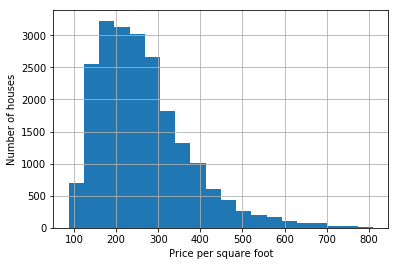

In [14]:
df.price_sqft.hist(bins=20)
plt.xlabel('Price per square foot')
plt.ylabel('Number of houses')

C:\Users\Yoga\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


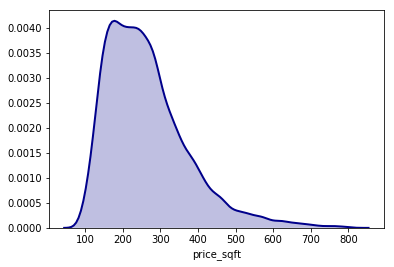

In [15]:
sns.distplot(df.price_sqft, hist=False, kde=True, kde_kws={'shade': True, 'linewidth':2}, color="darkblue")

Indeed, distribution of square foot price has right tail longer, mass of the distribution concentraced on the left side and few relatively high values.

## Independent variables

Number of bedrooms

Text(0,0.5,'Number of houses')

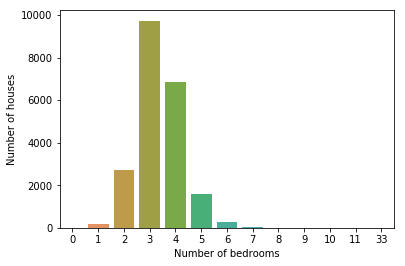

In [16]:
sns.countplot(x='bedrooms', data=df)
plt.xlabel('Number of bedrooms')
plt.ylabel('Number of houses')

In [17]:
df.bedrooms.value_counts()

3     9731
4     6849
2     2736
5     1586
6      265
      ... 
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, Length: 13, dtype: int64

Almost all houses contain below 10 bedrooms, however there is one observation with an extreme value, exceeding 30. Typical house in our database has 3 or 4 bedrooms.

In [18]:
df.bedrooms.describe()

count   21436.00
mean        3.37
std         0.93
min         0.00
25%         3.00
50%         3.00
75%         4.00
max        33.00
Name: bedrooms, dtype: float64

Indeed, we can see that maximum number of bedrooms is equal to 33. Let’s check if there are any other observations with more than 10 bedrooms.

In [19]:
df[df['bedrooms']>10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,price_sqft
2423,1773100755,2014-08-21,520000.00,11,3.00,3000,4960,2.00,0,0,3,7,2400,600,1918,1999,98106,47.56,-122.36,1420,4960,2014,173.33
4348,2402100895,2014-06-25,640000.00,33,1.75,1620,6000,1.00,0,0,5,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700,2014,395.06


There are two cases: one having 11 bedrooms, what may sound like a real value. Second one has 33 bedrooms what is definately an error. Taking into account overall area of the house, we may suppose that there should be 3 bedrooms. As long as we are not sure about it, in our opinion the best way is just to exclude this observation from our dataset.

In [20]:
df = df[df['bedrooms']!=33]

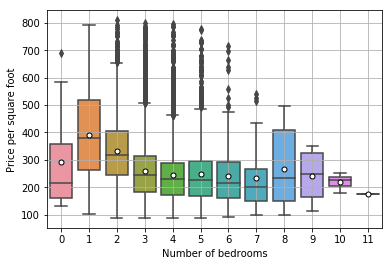

In [21]:
a_plot = sns.boxplot(y='price_sqft', x='bedrooms', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('Number of bedrooms')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

Number of bathrooms

Text(0,0.5,'Number of houses')

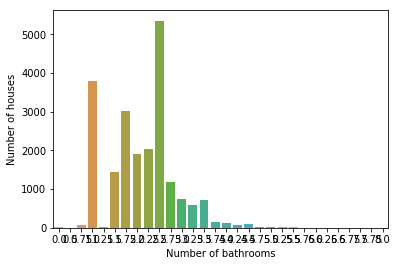

In [22]:
sns.countplot(x='bathrooms', data=df)
plt.xlabel('Number of bathrooms')
plt.ylabel('Number of houses')

In [23]:
df.bathrooms.value_counts()

2.50    5355
1.00    3795
1.75    3019
2.25    2031
2.00    1913
        ... 
6.25       2
6.75       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, Length: 30, dtype: int64

Number of bathrooms is concentraced between 0 and 8, however we can see that many values are fractional. The reason for this is specific categorization of bathrooms in USA (for example bathroom that consists of a toilet and sink is coded as 1/2, the one with a shower, sink and toilet is expressed as as 3/4 and sometimes even as 1 - generally it is quiet complicated case). For simplicity we decided to count only “full” bathrooms, therefore we have used floor for all values in this column.

In [24]:
df['bathrooms'] = df['bathrooms'].apply(np.floor).astype('int64')

Text(0,0.5,'Number of houses')

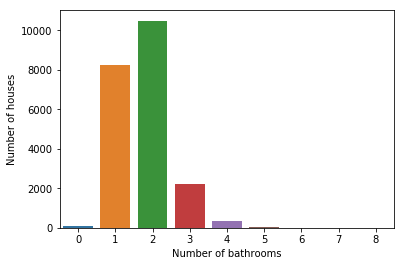

In [25]:
sns.countplot(x='bathrooms', data=df)
plt.xlabel('Number of bathrooms')
plt.ylabel('Number of houses')

In [26]:
df.bathrooms.value_counts()

2    10481
1     8253
3     2217
4      335
0       85
5       48
6       12
8        2
7        2
Name: bathrooms, dtype: int64

Now we can clearly see that typical house has 1 or 2 bathrooms.

In [27]:
df.bathrooms.describe()

count   21435.00
mean        1.75
std         0.73
min         0.00
25%         1.00
50%         2.00
75%         2.00
max         8.00
Name: bathrooms, dtype: float64

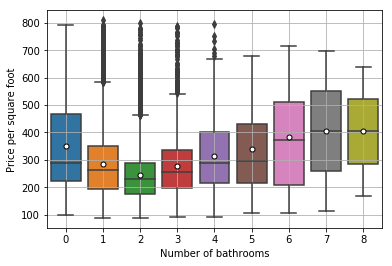

In [28]:
a_plot = sns.boxplot(y='price_sqft', x='bathrooms', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('Number of bathrooms')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

Living area

Text(0,0.5,'Number of houses')

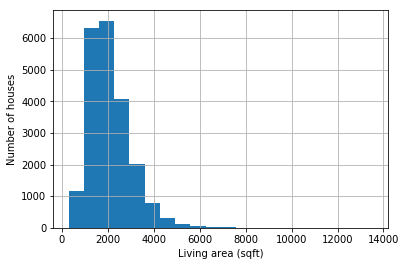

In [29]:
df.sqft_living.hist(bins=20)
plt.xlabel('Living area (sqft)')
plt.ylabel('Number of houses')

In [30]:
df.sqft_living.describe()

count   21435.00
mean     2082.73
std       919.16
min       290.00
25%      1430.00
50%      1920.00
75%      2550.00
max     13540.00
Name: sqft_living, dtype: float64

There are observations with very high sqft_living, especially one with 13540 (~ 1258 m2). Nevertheless, this still can be real value, as there exist such huge residences. Median and mean area of house are equal to 1920 sqft and 2083 sqft, respectively.

Text(0,0.5,'Price per square foot')

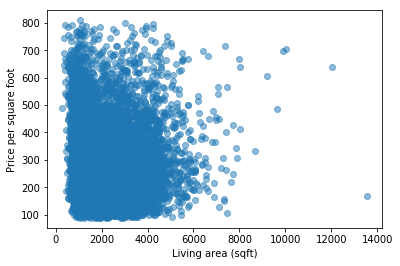

In [31]:
plt.scatter(df.sqft_living, df.price_sqft, alpha=0.5)
plt.xlabel('Living area (sqft)')
plt.ylabel('Price per square foot')

Number of floors

Text(0,0.5,'Number of houses')

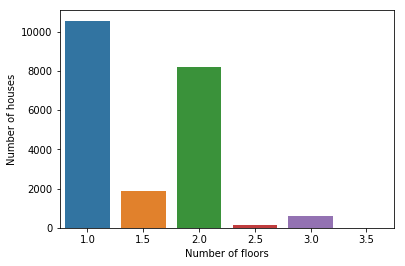

In [32]:
sns.countplot(x='floors', data=df)
plt.xlabel('Number of floors')
plt.ylabel('Number of houses')

In [33]:
df.floors.value_counts()

1.00    10558
2.00     8209
1.50     1888
3.00      611
2.50      161
3.50        8
Name: floors, dtype: int64

Great majority of houses have one or two floors. There also exist houses with 1.5 and 2.5 floors, where 0.5 may be considered as attic or half-floor. We will round these values up.

In [34]:
df['floors'] = df['floors'].apply(np.ceil).astype('int64')

Text(0,0.5,'Number of houses')

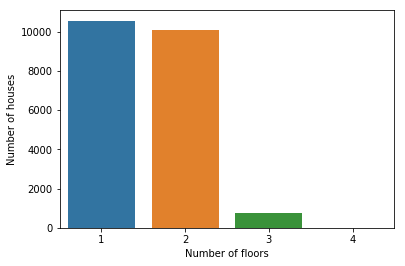

In [35]:
sns.countplot(x='floors', data=df)
plt.xlabel('Number of floors')
plt.ylabel('Number of houses')

In [36]:
df.floors.value_counts()

1    10558
2    10097
3      772
4        8
Name: floors, dtype: int64

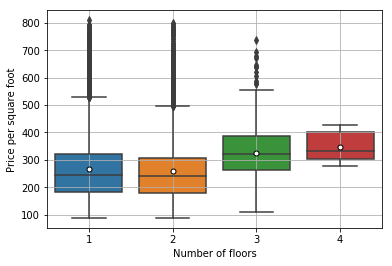

In [37]:
a_plot = sns.boxplot(y='price_sqft', x='floors', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('Number of floors')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

Does the house overlooking the waterfront?

Text(0,0.5,'Number of houses')

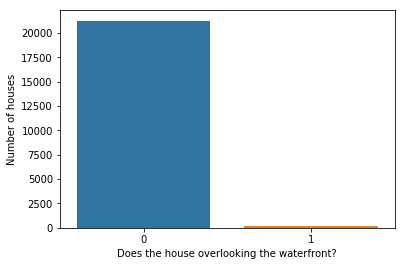

In [38]:
sns.countplot(x='waterfront', data=df)
plt.xlabel('Does the house overlooking the waterfront?')
plt.ylabel('Number of houses')

In [39]:
df.waterfront.value_counts()

0    21272
1      163
Name: waterfront, dtype: int64

Only very small fraction of houses have waterfront.

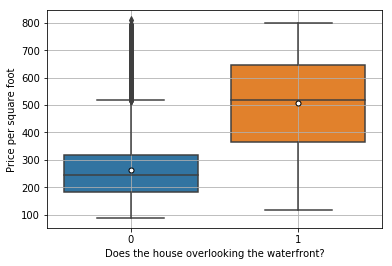

In [40]:
a_plot = sns.boxplot(y='price_sqft', x='waterfront', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('Does the house overlooking the waterfront?')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

View index

Text(0,0.5,'Number of houses')

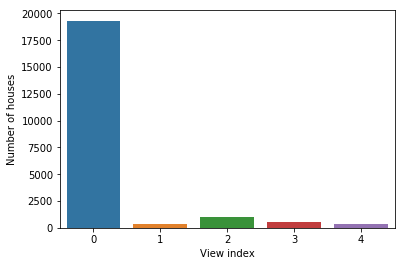

In [41]:
sns.countplot(x='view', data=df)
plt.xlabel('View index')
plt.ylabel('Number of houses')

In [42]:
df.view.value_counts()

0    19319
2      962
3      507
1      331
4      316
Name: view, dtype: int64

Majority of houses do not make spectacular view impressions.

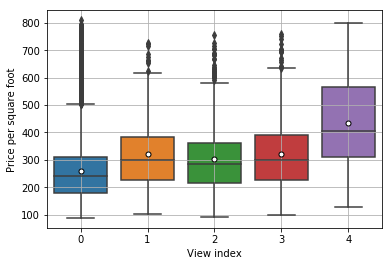

In [43]:
a_plot = sns.boxplot(y='price_sqft', x='view', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('View index')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

Condition of the house

Text(0,0.5,'Number of houses')

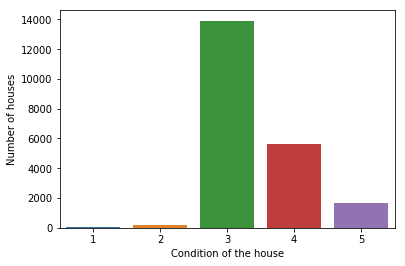

In [44]:
sns.countplot(x='condition', data=df)
plt.xlabel('Condition of the house')
plt.ylabel('Number of houses')

In [45]:
df.condition.value_counts()

3    13911
4     5645
5     1686
2      164
1       29
Name: condition, dtype: int64

Most frequently houses are of average condition (3), there is very low number of ‘fair’ (2) and ‘poor’ (1) houses. On the other side fractions of ‘good’ (4) and ‘very good’ (5) houses are significant.

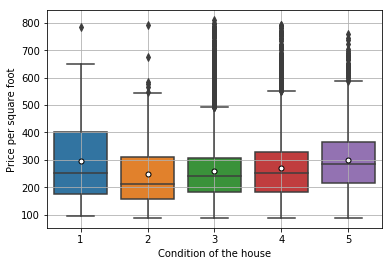

In [46]:
a_plot = sns.boxplot(y='price_sqft', x='condition', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('Condition of the house')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

Grade of the house

Text(0,0.5,'Number of houses')

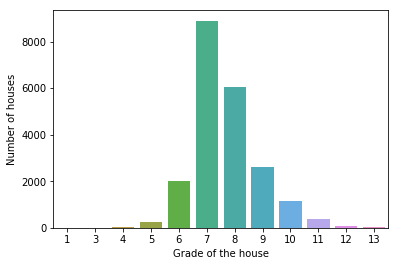

In [47]:
sns.countplot(x='grade', data=df)
plt.xlabel('Grade of the house')
plt.ylabel('Number of houses')

In [48]:
df.grade.value_counts()

7     8895
8     6044
9     2606
6     1995
10    1130
      ... 
12      89
4       29
13      13
3        3
1        1
Name: grade, Length: 12, dtype: int64

The most common grades of houses are ‘average’ (7) and ‘little above average’ (8).

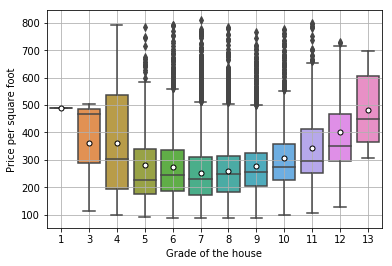

In [49]:
a_plot = sns.boxplot(y='price_sqft', x='grade', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('Grade of the house')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

Latitude and longitude

Text(0,0.5,'Latitude')

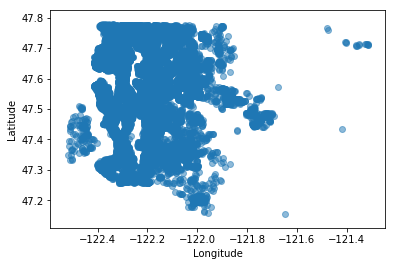

In [50]:
plt.scatter(df.long, df.lat, alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Houses are generally located in northwest area of the county. One of the reasons is that the largest cities are located there (e.g. Seattle). On the other side, there is very limited number of houses located in the east. That is mainly because this region is covered with national forest.

#### There are also several other variables in the dataset, but the results of their analysis has not been included in order not to contaminate the project.

## Regions segmentation and clustering

We will use the Foursquare API to explore regions in King County. With the use of explore function we will get the most common venue categories in each region described by zipcode. Then the regions will be grouped into clusters using k-means algorithm. At the end we will visualize the regions on map. Clustering results as well as top 3 venues for each region will be further used as featuers in regression.

We do not have exact regions in our dataset, however we can use another variable as an aproximation for this purpose. The variable 'zipcode' stands for postal code of each property in our dataset. I have checked if there exists possibility to map those zipcodes to respective neighborhoods, however there is no accessible dataset with zipcodes, neighborhoods and their coordinates in King County. Hence the 'zipcode' has been used as neighborhood identificator, and coordinates were calculated as average latitude and longitude calculated based on all estates assigned to particular zipcode.

In [51]:
neighborhoods = df.groupby('zipcode').agg({'lat': 'mean', 'long': 'mean'}).reset_index()
neighborhoods.columns = ['Neighborhood', 'Latitude', 'Longitude']
neighborhoods.head(5)

,Neighborhood,Latitude,Longitude
0,98001,47.31,-122.27
1,98002,47.31,-122.21
2,98003,47.32,-122.31
3,98004,47.62,-122.21
4,98005,47.61,-122.17


We can visualize our neighborhoods. Using geopy library I can get the latitude and longitude values of Bellevue city, which will be a good starting point on the map.

In [52]:
address = 'Bellevue, Washington, US'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

47.6144219 -122.1923372


Here is the map.

In [53]:
king_county_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(king_county_map)  
    
king_county_map

We can confirm that our neighborhoods based in zipcodes are indeed different regions in the county. Now we can start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [139]:
# Foursquare credentials
CLIENT_ID = 'XXXXX'
CLIENT_SECRET = 'XXXXX'
VERSION = '20201116'
LIMIT = 100

Below function explores regions in the dataset finding top 100 venues for each zipcode. At the beginning the analysis was performed with radius parameter equal 1000 (1km). It turned out that there is one neighborhoods without any venue within 1 km, hhence the radius parameter has been increased to 2500 (2.5km).

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
king_county_venues = getNearbyVenues(names=neighborhoods['zipcode'],
                                   latitudes=neighborhoods['latitude'],
                                   longitudes=neighborhoods['longitude'])

98001
98002
98003
98004
98005
98006
98007
98008
98010
98011
98014
98019
98022
98023
98024
98027
98028
98029
98030
98031
98032
98033
98034
98038
98039
98040
98042
98045
98052
98053
98055
98056
98058
98059
98065
98070
98072
98074
98075
98077
98092
98102
98103
98105
98106
98107
98108
98109
98112
98115
98116
98117
98118
98119
98122
98125
98126
98133
98136
98144
98146
98148
98155
98166
98168
98177
98178
98188
98198
98199


We can see how many venues were returned for each neighborhood

In [160]:
king_county_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
98001,65,65,65,65,65,65
98002,100,100,100,100,100,100
98003,100,100,100,100,100,100
98004,100,100,100,100,100,100
98005,100,100,100,100,100,100
...,...,...,...,...,...,...
98177,64,64,64,64,64,64
98178,20,20,20,20,20,20
98188,100,100,100,100,100,100


In [54]:
#Save the file so I do not have to make requests each time I open the project
#king_county_venues.to_pickle("king_county_venues2500.pkl")
king_county_venues = pd.read_pickle("king_county_venues2500.pkl")

With the use of Foursquare data we cane prepare dataframe that will be used for clustering.

In [55]:
king_county_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,98001,47.31,-122.27,The Coffee Bear,47.32,-122.28,Coffee Shop
1,98001,47.31,-122.27,Nordstrom Rack,47.30,-122.25,Clothing Store
2,98001,47.31,-122.27,Victoria's Secret PINK,47.30,-122.25,Lingerie Store
3,98001,47.31,-122.27,Marlene's Market & Deli,47.32,-122.30,Grocery Store
4,98001,47.31,-122.27,Starbucks,47.30,-122.25,Coffee Shop


In [56]:
king_county_onehot = pd.get_dummies(king_county_venues[['Venue Category']], prefix="", prefix_sep="")
king_county_onehot.drop(columns=['Neighborhood'], inplace=True)
king_county_onehot['Neighborhood'] = king_county_venues['Neighborhood'] 
fixed_columns = [king_county_onehot.columns[-1]] + list(king_county_onehot.columns[:-1])
king_county_onehot = king_county_onehot[fixed_columns]
king_county_onehot.head(5)

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Launch,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Caribbean Restaurant,Casino,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Science Building,College Theater,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Cuban Restaurant,Cupcake Shop,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,RV Park,Racetrack,Radio Station,Ramen Restaurant,Real Estate Office,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roller Rink,Russian Restaurant,Salad Place,Salon / Barbershop,Sand

In [57]:
king_county_grouped = king_county_onehot.groupby('Neighborhood').mean().reset_index()
king_county_grouped.head(5)

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat Launch,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal Lock,Candy Store,Caribbean Restaurant,Casino,Chaat Place,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Gym,College Science Building,College Theater,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Credit Union,Cuban Restaurant,Cupcake Shop,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Dosa Place,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean BBQ Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Motorsports Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,RV Park,Racetrack,Radio Station,Ramen Restaurant,Real Estate Office,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roller Rink,Russian Restaurant,Salad Place,Salon / Barbershop,Sand

We can also display to 10 venues for each neighborhood.

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = king_county_grouped['Neighborhood']

for ind in np.arange(king_county_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(king_county_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98001,Clothing Store,Sandwich Place,Furniture / Home Store,Coffee Shop,Hotel,Ice Cream Shop,Shopping Mall,Lingerie Store,Sporting Goods Shop,Kids Store
1,98002,Coffee Shop,Fast Food Restaurant,Convenience Store,Sandwich Place,Pizza Place,American Restaurant,Automotive Shop,Pharmacy,Bank,Mexican Restaurant
2,98003,Korean Restaurant,Coffee Shop,Mexican Restaurant,Grocery Store,Burger Joint,Thai Restaurant,Café,Ice Cream Shop,Pet Store,Vietnamese Restaurant
3,98004,Coffee Shop,Italian Restaurant,Hotel,Pizza Place,Shopping Mall,Clothing Store,Spa,Steakhouse,Toy / Game Store,Sushi Restaurant
4,98005,Coffee Shop,Gym,Grocery Store,Spa,Sandwich Place,Pet Store,Sushi Restaurant,Steakhouse,Bakery,Shopping Mall


Finally we can run k-means algorithm to cluser the neighborhoods.

In [60]:
kclusters = 5
king_county_grouped_clustering = king_county_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(king_county_grouped_clustering)

And create a dataset with cluster assignment as well as top 10 venues for each neighborhood.

In [61]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
king_county_merged = neighborhoods

king_county_merged = king_county_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
king_county_merged.head(5)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98001,47.31,-122.27,4,Clothing Store,Sandwich Place,Furniture / Home Store,Coffee Shop,Hotel,Ice Cream Shop,Shopping Mall,Lingerie Store,Sporting Goods Shop,Kids Store
1,98002,47.31,-122.21,0,Coffee Shop,Fast Food Restaurant,Convenience Store,Sandwich Place,Pizza Place,American Restaurant,Automotive Shop,Pharmacy,Bank,Mexican Restaurant
2,98003,47.32,-122.31,0,Korean Restaurant,Coffee Shop,Mexican Restaurant,Grocery Store,Burger Joint,Thai Restaurant,Café,Ice Cream Shop,Pet Store,Vietnamese Restaurant
3,98004,47.62,-122.21,4,Coffee Shop,Italian Restaurant,Hotel,Pizza Place,Shopping Mall,Clothing Store,Spa,Steakhouse,Toy / Game Store,Sushi Restaurant
4,98005,47.61,-122.17,4,Coffee Shop,Gym,Grocery Store,Spa,Sandwich Place,Pet Store,Sushi Restaurant,Steakhouse,Bakery,Shopping Mall


Size of clusters

In [62]:
king_county_merged['Cluster Labels'].value_counts()

0    32
4    20
1    16
3     1
2     1
Name: Cluster Labels, dtype: int64

#### We can finally visualize our clusters on map.

In [63]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(king_county_merged['Latitude'], king_county_merged['Longitude'], king_county_merged['Neighborhood'], king_county_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.25).add_to(map_clusters)
       
map_clusters

We can explore each cluster in more detail in order to label it in meaningful way.

First cluster

In [64]:
king_county_merged.loc[king_county_merged['Cluster Labels'] == 0, ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].apply(pd.Series.value_counts).sort_values(['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue'], ascending=False).head(5)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Coffee Shop,19.00,4.00,2.00
Pizza Place,4.00,9.00,3.00
Sandwich Place,2.00,2.00,3.00
Vietnamese Restaurant,2.00,2.00,1.00
Convenience Store,1.00,2.00,1.00


Second cluster

In [65]:
king_county_merged.loc[king_county_merged['Cluster Labels'] == 1, ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].apply(pd.Series.value_counts).sort_values(['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue'], ascending=False).head(5)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Park,8.00,3.00,1.00
Trail,4.00,1.00,nan
Farm,2.00,nan,nan
Beach,1.00,nan,1.00
Airport,1.00,nan,nan


Third cluster

In [66]:
king_county_merged.loc[king_county_merged['Cluster Labels'] == 2, ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].apply(pd.Series.value_counts).sort_values(['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue'], ascending=False).head(5)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Food,1.00,nan,nan
Performing Arts Venue,nan,1.00,nan
Boat or Ferry,nan,nan,1.00


Forth cluster

In [67]:
king_county_merged.loc[king_county_merged['Cluster Labels'] == 3, ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].apply(pd.Series.value_counts).sort_values(['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue'], ascending=False).head(5)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
River,1.00,nan,nan
New American Restaurant,nan,1.00,nan
Trail,nan,nan,1.00


Fifth cluster

In [68]:
king_county_merged.loc[king_county_merged['Cluster Labels'] == 4, ['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']].apply(pd.Series.value_counts).sort_values(['1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue'], ascending=False).head(5)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
Coffee Shop,16.00,1.00,nan
Brewery,1.00,1.00,1.00
Grocery Store,1.00,nan,1.00
Bar,1.00,nan,nan
Clothing Store,1.00,nan,nan


Last step is to append our new clusters and top 3 venues for each region to the main dataset.

In [69]:
df = pd.merge(left=df, right=king_county_merged[['Neighborhood', 'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']], how='left', left_on='zipcode', right_on='Neighborhood')
df.drop(columns=['Neighborhood'], inplace=True)
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,price_sqft,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,1000102,2015-04-22,300000.00,6,3,2400,9373,2,0,0,3,7,2400,0,1991,0,98002,47.33,-122.21,2060,7316,2015,125.00,0,Coffee Shop,Fast Food Restaurant,Convenience Store
1,100100050,2014-11-12,275000.00,3,1,1320,11090,1,0,0,3,7,1320,0,1955,0,98155,47.77,-122.30,1320,8319,2014,208.33,0,Pizza Place,Coffee Shop,Park
2,1001200035,2015-03-06,272450.00,3,1,1350,7973,2,0,0,3,7,1350,0,1954,0,98188,47.43,-122.29,1310,7491,2015,201.81,4,Coffee Shop,Hotel,Cosmetics Shop
3,1001200050,2014-09-23,259000.00,4,1,1260,7248,2,0,0,5,7,1260,0,1955,0,98188,47.43,-122.29,1300,7732,2014,205.56,4,Coffee Shop,Hotel,Cosmetics Shop
4,1003000175,2014-12-22,221000.00,3,1,980,7606,1,0,0,3,7,980,0,1954,0,98188,47.44,-122.29,980,8125,2014,225.51,4,Coffee Shop,Hotel,Cosmetics Shop


We will transforme Cluster Labels from integer to object as we will use this variable as a label.

In [70]:
df['Cluster Labels'] = df['Cluster Labels'].astype(str)

#### Now we can explore new features in terms of relationship with house price per square foot.

Cluster label

Text(0,0.5,'Number of houses')

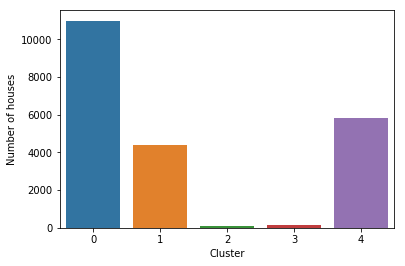

In [71]:
sns.countplot(x='Cluster Labels', data=df)
plt.xlabel('Cluster')
plt.ylabel('Number of houses')

In [72]:
df['Cluster Labels'].value_counts()

0    10984
4     5799
1     4412
3      123
2      117
Name: Cluster Labels, dtype: int64

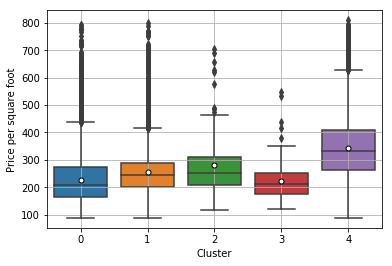

In [73]:
a_plot = sns.boxplot(y='price_sqft', x='Cluster Labels', data=df,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.xlabel('Cluster')
plt.ylabel('Price per square foot')
plt.grid()
plt.show()

1st Most Common Venue

In [74]:
table = df.groupby('1st Most Common Venue').agg({'price_sqft': 'mean', '1st Most Common Venue': 'first', 'id': 'size'}).sort_values('id', ascending=False)
table_order = list(table['1st Most Common Venue'])

Text(0,0.5,'Number of houses')

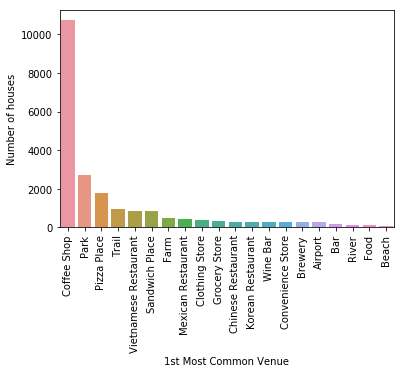

In [75]:
sns.countplot(x='1st Most Common Venue', data=df, order=table_order)
plt.xticks(rotation=90)
plt.xlabel('1st Most Common Venue')
plt.ylabel('Number of houses')

In [76]:
df['1st Most Common Venue'].value_counts()

Coffee Shop              10744
Park                      2698
Pizza Place               1753
Trail                      925
Vietnamese Restaurant      839
                         ...  
Airport                    258
Bar                        185
River                      123
Food                       117
Beach                       49
Name: 1st Most Common Venue, Length: 20, dtype: int64

In [77]:
table.sort_values('price_sqft', ascending=False, inplace=True)
table_order = list(table['1st Most Common Venue'])

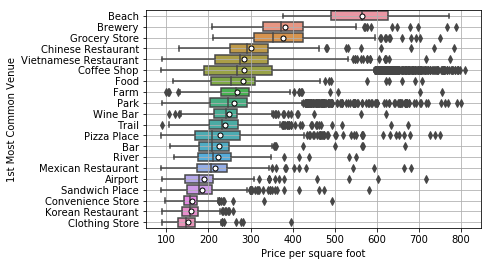

In [78]:
a_plot = sns.boxplot(x='price_sqft', y='1st Most Common Venue', data=df,
                    order=table_order,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.ylabel('1st Most Common Venue')
plt.xlabel('Price per square foot')
plt.grid()
plt.show()

2nd Most Common Venue

In [79]:
table = df.groupby('2nd Most Common Venue').agg({'price_sqft': 'mean', '2nd Most Common Venue': 'first', 'id': 'size'}).sort_values('id', ascending=False)
table_order = list(table['2nd Most Common Venue'])

Text(0,0.5,'Number of houses')

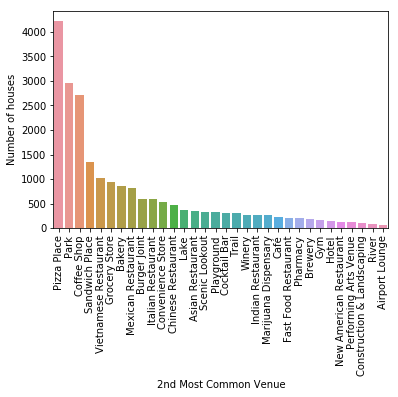

In [80]:
sns.countplot(x='2nd Most Common Venue', data=df, order=table_order)
plt.xticks(rotation=90)
plt.xlabel('2nd Most Common Venue')
plt.ylabel('Number of houses')

In [81]:
df['2nd Most Common Venue'].value_counts()

Pizza Place                   4224
Park                          2951
Coffee Shop                   2721
Sandwich Place                1349
Vietnamese Restaurant         1028
                              ... 
New American Restaurant        123
Performing Arts Venue          117
Construction & Landscaping      99
River                           80
Airport Lounge                  56
Name: 2nd Most Common Venue, Length: 32, dtype: int64

In [82]:
table.sort_values('price_sqft', ascending=False, inplace=True)
table_order = list(table['2nd Most Common Venue'])

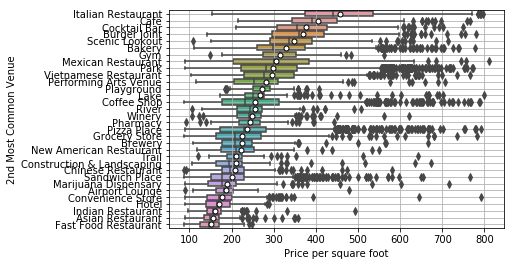

In [83]:
a_plot = sns.boxplot(x='price_sqft', y='2nd Most Common Venue', data=df,
                    order=table_order,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.ylabel('2nd Most Common Venue')
plt.xlabel('Price per square foot')
plt.grid()
plt.show()

3rd Most Common Venue

In [84]:
table = df.groupby('3rd Most Common Venue').agg({'price_sqft': 'mean', '3rd Most Common Venue': 'first', 'id': 'size'}).sort_values('id', ascending=False)
table_order = list(table['3rd Most Common Venue'])

Text(0,0.5,'Number of houses')

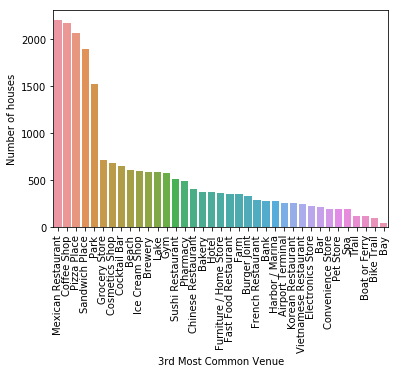

In [85]:
sns.countplot(x='3rd Most Common Venue', data=df, order=table_order)
plt.xticks(rotation=90)
plt.xlabel('3rd Most Common Venue')
plt.ylabel('Number of houses')

In [86]:
df['3rd Most Common Venue'].value_counts()

Mexican Restaurant    2198
Coffee Shop           2169
Pizza Place           2065
Sandwich Place        1894
Park                  1519
                      ... 
Spa                    190
Trail                  123
Boat or Ferry          117
Bike Trail              99
Bay                     49
Name: 3rd Most Common Venue, Length: 37, dtype: int64

In [87]:
table.sort_values('price_sqft', ascending=False, inplace=True)
table_order = list(table['3rd Most Common Venue'])

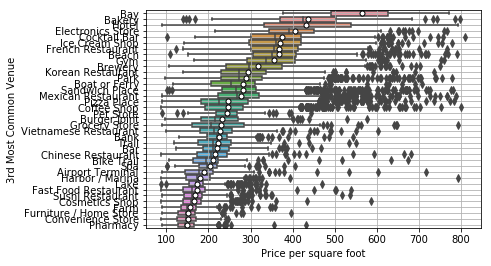

In [88]:
a_plot = sns.boxplot(x='price_sqft', y='3rd Most Common Venue', data=df,
                    order=table_order,
                    showmeans=True,
                    meanprops={'marker':'o',
                              'markerfacecolor':'white',
                              'markeredgecolor':'black',
                              'markersize':'5'})
plt.ylabel('3rd Most Common Venue')
plt.xlabel('Price per square foot')
plt.grid()
plt.show()

## Model estimation

Below function calculates Mean Absolute Percentage Error (MAPE). We will use MAPE as it provides intuitive and easy to interpret results.

In [89]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### First, let's look at how multiple linear regression deals with this problem to have a benchmark model

We will not perform any other data preprocessing and feature selection for linear regression as this model will serve only as a banchmark. However we have some categorical variables so we need to transform them into dummies.

In [90]:
features = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue']]

In [91]:
features = pd.get_dummies(data=features, drop_first=True)

Create two datasets X with all features and y with target variable

In [92]:
X = features.values
y = df['price_sqft'].values

Split into train / test sample (80%/20%)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

Model estimation

In [94]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Model evaluation

In [95]:
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

In [96]:
print('MAPE for the train dataset equals:', round(mape(y_train, predictions_train),2))
print('MAPE for the test dataset equals:', round(mape(y_test, predictions_test),2))

MAPE for the train dataset equals: 15.43
MAPE for the test dataset equals: 15.67


#### As we already have a benchmark results we can now estimate more advanced model, i.e. catboost

In [97]:
features = df[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue']]

Create two datasets X with all features and y with target variable

In [98]:
X = features
y = df['price_sqft']

Split into train / test sample (80%/20%)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

Preparation of numeric/categorical variables for catboost algorithm

In [100]:
def is_str(col):
    for i in col:
        if pd.isnull(i):
            continue
        elif isinstance(i, str):
            return True
        else:
            return False

def split_features(df):
    cfc = []
    nfc = []
    for column in df:
        if is_str(df[column]):
            cfc.append(column)
        else:
            nfc.append(column)
    return df[cfc], df[nfc]

In [101]:
cat_tmp_train, num_tmp_train = split_features(X_train)
cat_tmp_test, num_tmp_test = split_features(X_test)

In [102]:
train_pool = Pool(
    data = FeaturesData(num_feature_data = np.array(num_tmp_train.values, dtype=np.float32), 
                    cat_feature_data = np.array(cat_tmp_train.values, dtype=object), 
                    num_feature_names = list(num_tmp_train.columns.values), 
                    cat_feature_names = list(cat_tmp_train.columns.values)),
    label =  np.array(y_train, dtype=np.float32)
)

In [103]:
test_pool = Pool(
    data = FeaturesData(num_feature_data = np.array(num_tmp_test.values, dtype=np.float32), 
                    cat_feature_data = np.array(cat_tmp_test.values, dtype=object), 
                    num_feature_names = list(num_tmp_test.columns.values), 
                    cat_feature_names = list(cat_tmp_test.columns.values))
)

Model estimation

In [104]:
model_catboost = CatBoostRegressor(iterations=2000, learning_rate=0.05, depth=5)
model_catboost.fit(train_pool, verbose=5000)

0:	learn: 107.3352633	total: 457ms	remaining: 15m 13s
1999:	learn: 35.0931165	total: 1m 13s	remaining: 0us


Model evaluation

In [105]:
predictions_train = model_catboost.predict(train_pool)
predictions_test = model_catboost.predict(test_pool)

In [106]:
print('MAPE for the train dataset equals:', round(mape(y_train, predictions_train),2))
print('MAPE for the test dataset equals:', round(mape(y_test, predictions_test),2))

MAPE for the train dataset equals: 9.74
MAPE for the test dataset equals: 11.55


We can see that Catboost model is significantly better than Multiple Linear Regression. Now we can evaluate whether our new created variables improved predictive power of the model.

In [107]:
feature_score = pd.DataFrame(list(zip(features.columns.values, model_catboost.feature_importances_)), 
                             columns=['Feature', 'Score']).sort_values('Score', ascending=True)

Text(0.5,1,'Catboost feature importance ranking')

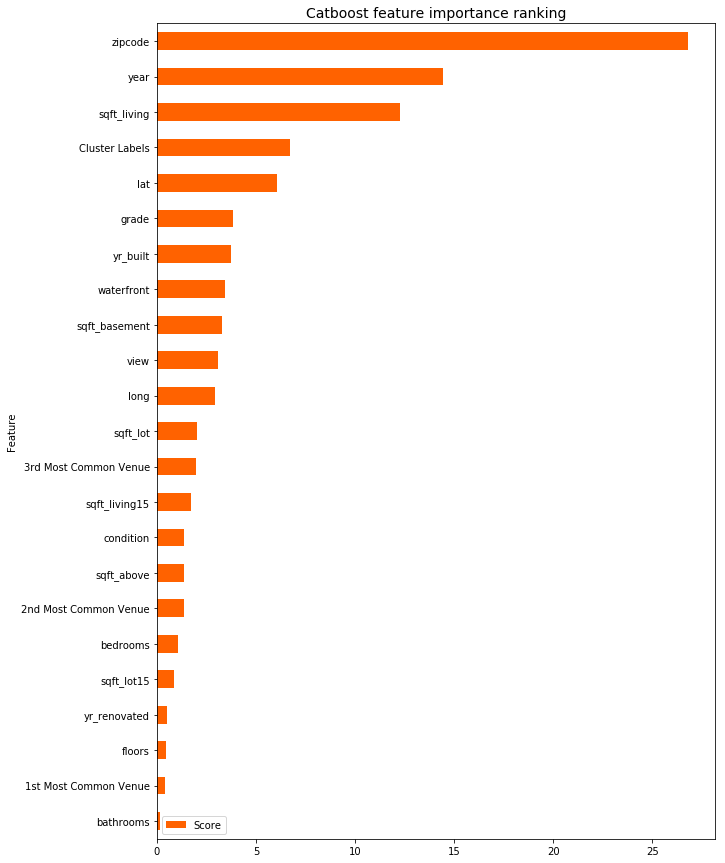

In [108]:
ax = feature_score.plot('Feature', 'Score', kind='barh',
                       color='#ff6200', figsize=(10,15))

ax.set_title('Catboost feature importance ranking', fontsize=14)

We can see that one of new variables created based on Foursquare data (Cluster Labels) is among 5 most imporant variables in our model. Hence we can consider that Foursquare data gave some value added to our prediction.

At the end we can visualize our houses on map and color them depending on price per square foot.

In [109]:
df['price_bucket'] = '10'
df.loc[df.price<df.price.quantile(0.9), 'price_bucket'] = '9'
df.loc[df.price<df.price.quantile(0.8), 'price_bucket'] = '8'
df.loc[df.price<df.price.quantile(0.7), 'price_bucket'] = '7'
df.loc[df.price<df.price.quantile(0.6), 'price_bucket'] = '6'
df.loc[df.price<df.price.quantile(0.5), 'price_bucket'] = '5'
df.loc[df.price<df.price.quantile(0.4), 'price_bucket'] = '4'
df.loc[df.price<df.price.quantile(0.3), 'price_bucket'] = '3'
df.loc[df.price<df.price.quantile(0.2), 'price_bucket'] = '2'
df.loc[df.price<df.price.quantile(0.1), 'price_bucket'] = '1'
df['price_bucket'] = df['price_bucket'].astype('int64')

Red markers represent the higher prices per square foot, while blue markers the lower prices.